# 단기 메모리 (Short-term Memory)

메모리(Memory) 는 AI가 이전 상호작용의 정보를 기억하는 시스템입니다.
이 기능 덕분에 AI는 과거 대화를 기억하고, 피드백에서 학습하며, 사용자의 선호도에 맞게 적응할 수 있습니다.  
에이전트가 여러 번의 사용자 상호작용을 포함한 복잡한 작업을 수행할 때, 이러한 메모리 기능은 효율성과 사용자 만족도를 위해 필수적입니다.

단기 메모리는 하나의 스레드(thread) 또는 대화(conversation) 내에서 이전 상호작용을 기억하게 해줍니다.  
하나의 스레드(thread) 는 이메일이 여러 메시지를 하나의 대화로 묶는 것처럼, 여러 상호작용을 하나의 세션으로 구성합니다.

가장 일반적인 단기 메모리 형태는 **대화 이력(conversation history)** 입니다.

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain.chat_models import init_chat_model

# model = init_chat_model("gpt-5-nano", model_provider="openai")
model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

채팅 모델은 **메시지(messages)** 를 사용해 문맥(context)을 전달받습니다.
이 메시지에는 **지시(instruction)** 역할의 시스템 메시지와, **입력(input)** 역할의 사용자 메시지가 포함됩니다.

에이전트에 **단기 메모리(스레드 수준 지속성)** 를 추가하려면, 에이전트를 생성할 때 **체크포인터(checkpointer)** 를 지정해야 합니다.

In [4]:
from langchain.agents import create_agent
from langgraph.checkpoint.memory import InMemorySaver  
from langchain.tools import tool

@tool
def search_db(query: str, limit: int = 10) -> str:
    """검색어(query)에 해당하는 고객 데이터베이스 레코드를 조회합니다.

    Args:
        query: 검색할 키워드 또는 문장
        limit: 반환할 최대 결과 개수
    """
    return f"'{query}'에 대한 검색 결과 {limit}개를 찾았습니다."

tools = [search_db]

agent = create_agent(
    model,
    tools,
    checkpointer=InMemorySaver(),  # 단기 메모리(체크포인터) 추가
)

# 에이전트 실행
agent.invoke(
    {"messages": [{"role": "user", "content": "안녕! 내 이름은 밥이야."}]},
    {"configurable": {"thread_id": "1"}},  # 스레드(대화) ID 지정
)

{'messages': [HumanMessage(content='안녕! 내 이름은 밥이야.', additional_kwargs={}, response_metadata={}, id='7e197f2d-6f54-4592-b1be-a70967f28216'),
  AIMessage(content='안녕하세요 밥님! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--17752927-a48e-4aa4-b427-f159fba8865b-0', usage_metadata={'input_tokens': 102, 'output_tokens': 11, 'total_tokens': 113, 'input_token_details': {'cache_read': 0}})]}

운영 환경에서는 데이터베이스로 지원되는 체크포인터를 사용합니다.

In [5]:
# pip install -U langgraph-checkpoint-sqlite

In [6]:
from langchain.agents import create_agent
from langgraph.checkpoint.sqlite import SqliteSaver

# SQLite 데이터베이스 파일 경로
DB_PATH = "checkpoints.db"  # 또는 원하는 경로/파일명

with SqliteSaver.from_conn_string(DB_PATH) as checkpointer:
    checkpointer.setup()  # SQLite 테이블 자동 생성
    agent = create_agent(
        model,
        tools,
        checkpointer=checkpointer,
    )

### 에이전트 메모리 사용자 정의

기본적으로 에이전트는 **`AgentState`** 를 사용하여 **단기 메모리(short-term memory)** 를 관리합니다.
특히, 대화 이력(conversation history)은 `messages` 키를 통해 저장됩니다.

`AgentState`를 **확장(extend)** 하면, 여기에 **추가 필드(custom fields)** 를 넣을 수도 있습니다.
사용자 정의 상태 스키마(custom state schema)는 `create_agent` 함수에 **`state_schema` 매개변수**로 전달됩니다. 

In [7]:
from langchain.agents import create_agent, AgentState
from langgraph.checkpoint.memory import InMemorySaver

class CustomAgentState(AgentState):  
    user_id: str
    preferences: dict

agent = create_agent(
    model,
    tools,
    state_schema=CustomAgentState,  # 사용자 정의 상태 스키마 등록
    checkpointer=InMemorySaver(),   # 단기 메모리 저장소
)

# 사용자 정의 상태를 포함하여 호출
result = agent.invoke(
    {
        "messages": [{"role": "user", "content": "안녕하세요"}],
        "user_id": "user_123",             # 사용자 ID 추가
        "preferences": {"theme": "dark"}   # 사용자 선호도 추가
    },
    {"configurable": {"thread_id": "1"}}   # 동일 스레드에서 지속적 대화 유지
)

result

{'messages': [HumanMessage(content='안녕하세요', additional_kwargs={}, response_metadata={}, id='ae5fe742-45a7-4c6d-96bc-ebcc0445ba98'),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--ea7d1a34-72dd-4763-aa33-54a855e141f6-0', usage_metadata={'input_tokens': 93, 'output_tokens': 8, 'total_tokens': 101, 'input_token_details': {'cache_read': 0}})],
 'user_id': 'user_123',
 'preferences': {'theme': 'dark'}}

In [8]:
result['messages']

[HumanMessage(content='안녕하세요', additional_kwargs={}, response_metadata={}, id='ae5fe742-45a7-4c6d-96bc-ebcc0445ba98'),
 AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--ea7d1a34-72dd-4763-aa33-54a855e141f6-0', usage_metadata={'input_tokens': 93, 'output_tokens': 8, 'total_tokens': 101, 'input_token_details': {'cache_read': 0}})]

In [9]:
result['user_id']

'user_123'

In [10]:
result['preferences']

{'theme': 'dark'}

### 메시지 트리밍 (Trim messages)
대부분의 LLM은 최대 지원 컨텍스트 윈도우(토큰 단위로 표시)가 있습니다. 메시지를 언제 잘라낼지 결정하는 한 가지 방법은 메시지 히스토리의 토큰을 계산하고 제한에 근접할 때마다 잘라내는 것입니다.  
LangChain을 사용하는 경우, trim messages 유틸리티를 사용하여 목록에서 유지할 토큰 수와 경계를 처리하는 strategy(예: 마지막 max_tokens 유지)를 지정할 수 있습니다.  
에이전트에서 메시지 히스토리를 트리밍하려면 @before_model 미들웨어 데코레이터를 사용하세요:

In [11]:
from langchain.messages import RemoveMessage
from langgraph.graph.message import REMOVE_ALL_MESSAGES
from langgraph.checkpoint.memory import InMemorySaver
from langchain.agents import create_agent, AgentState
from langchain.agents.middleware import before_model
from langgraph.runtime import Runtime
from langchain_core.runnables import RunnableConfig
from typing import Any

@before_model
def trim_messages(state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
    """컨텍스트 윈도우에 맞추기 위해 최근 몇 개의 메시지만 유지합니다."""
    messages = state["messages"]
    
    # 메시지가 3개 이하면 트리밍 불필요
    if len(messages) <= 3:
        return None  # 변경사항 없음
    
    # 첫 번째 메시지 보존 (보통 시스템 메시지나 초기 컨텍스트)
    first_msg = messages[0]
    
    # 최근 3-4개 메시지 선택 (대화의 자연스러운 흐름 유지를 위해 짝수/홀수 고려)
    recent_messages = messages[-3:] if len(messages) % 2 == 0 else messages[-4:]
    
    # 새로운 메시지 리스트 구성
    new_messages = [first_msg] + recent_messages
    
    # 모든 기존 메시지를 제거하고 새 메시지로 교체
    return {
        "messages": [
            RemoveMessage(id=REMOVE_ALL_MESSAGES),  # 모든 메시지 제거
            *new_messages  # 선택된 메시지만 다시 추가
        ]
    }

# 에이전트 생성 (모델, 도구, 미들웨어, 체크포인터 설정)
agent = create_agent(
    model,
    tools=tools,
    middleware=[trim_messages],  # 메시지 트리밍 미들웨어 적용
    checkpointer=InMemorySaver(),  # 메모리 기반 체크포인터
)

# 설정: thread_id로 대화 세션 식별
config: RunnableConfig = {"configurable": {"thread_id": "1"}}

# 대화 시작 - 이름 소개
agent.invoke({"messages": "안녕, 내 이름은 밥이야"}, config)

# 고양이에 대한 짧은 시 요청
agent.invoke({"messages": "고양이에 대한 짧은 시를 써줘"}, config)

# 개에 대한 시 요청
agent.invoke({"messages": "이제 개에 대해서도 똑같이 해줘"}, config)

# 이전에 말한 이름을 기억하는지 확인 (메시지 트리밍 후에도 기억하는지 테스트)
final_response = agent.invoke({"messages": "내 이름이 뭐야?"}, config)

# 최종 응답 출력
final_response["messages"][-1].pretty_print()

================================== Ai Message ==================================

당신은 "밥"이라고 말씀해주셨어요!


### Message 삭제
그래프 State에서 메시지를 삭제하려면 **`RemoveMessage`** 를 사용할 수 있습니다.  
단, `RemoveMessage` 가 제대로 동작하려면 `add_messages` 리듀서(reducer)를 사용하는 상태 키(state key)가 필요합니다.  
기본 제공되는 **`AgentState`** 는 이미 이 기능을 포함하고 있습니다.

In [12]:
from langchain.messages import RemoveMessage  

def delete_messages(state):
    messages = state["messages"]
    if len(messages) > 2:
        # 가장 오래된 두 개의 메시지를 제거
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:2]]}

- 모든 message 를 삭제하려면,

In [13]:
from langgraph.graph.message import REMOVE_ALL_MESSAGES

def delete_messages(state):
    return {"messages": [RemoveMessage(id=REMOVE_ALL_MESSAGES)]}

- 가장 오래된 두개의 message 삭제 예시

In [20]:
from langchain.messages import RemoveMessage
from langchain.agents import create_agent, AgentState
from langchain.agents.middleware import after_model
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.runtime import Runtime
from langchain_core.runnables import RunnableConfig

@after_model
def delete_old_messages(state: AgentState, runtime: Runtime) -> dict | None:
    """대화가 너무 길어지지 않도록 오래된 메시지를 삭제합니다."""
    messages = state["messages"]
    if len(messages) > 2:
        # 가장 오래된 두 개의 메시지를 제거
        print("\n[delete_old_messages] 삭제된 메시지:")
        for m in messages[:2]:
            print(f" - ({m.type}) {m.content}")
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:2]]}
    return None

# 에이전트 생성
agent = create_agent(
    model,
    tools=[],
    system_prompt="간결하고 핵심만 답변하세요.",
    middleware=[delete_old_messages],  # 오래된 메시지 삭제 미들웨어 추가
    checkpointer=InMemorySaver(),      # 인메모리 체크포인터 (단기 메모리)
)

# 실행 설정 (스레드 ID로 대화 지속)
config: RunnableConfig = {"configurable": {"thread_id": "1"}}

# 첫 번째 대화
print("******* 첫번째 대화 ************")
for event in agent.stream(
    {"messages": [{"role": "user", "content": "안녕! 내 이름은 밥이야."}]},
    config,
    stream_mode="values",
):
    print([(message.type, message.content) for message in event["messages"]])

# 두 번째 대화
print("\n******* 두번째 대화 ************")
for event in agent.stream(
    {"messages": [{"role": "user", "content": "내 이름이 뭐였지?"}]},
    config,
    stream_mode="values",
):
    print([(message.type, message.content) for message in event["messages"]])

******* 첫번째 대화 ************
[('human', '안녕! 내 이름은 밥이야.')]
[('human', '안녕! 내 이름은 밥이야.'), ('ai', '안녕, 밥!')]

******* 두번째 대화 ************
[('human', '안녕! 내 이름은 밥이야.'), ('ai', '안녕, 밥!'), ('human', '내 이름이 뭐였지?')]
[('human', '안녕! 내 이름은 밥이야.'), ('ai', '안녕, 밥!'), ('human', '내 이름이 뭐였지?'), ('ai', '밥.')]

[delete_old_messages] 삭제된 메시지:
 - (human) 안녕! 내 이름은 밥이야.
 - (ai) 안녕, 밥!
[('human', '내 이름이 뭐였지?'), ('ai', '밥.')]


In [21]:
agent.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='내 이름이 뭐였지?', additional_kwargs={}, response_metadata={}, id='83dc2cac-ed72-4e6e-92c0-fc041591be82'), AIMessage(content='밥.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--976b0e94-f5f2-4179-8b03-572b5903a4ea-0', usage_metadata={'input_tokens': 34, 'output_tokens': 27, 'total_tokens': 61, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 25}})]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b2cae-7a2f-61ea-8006-02a4093cb77b'}}, metadata={'source': 'loop', 'step': 6, 'parents': {}}, created_at='2025-10-27T00:21:38.783849+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b2cae-7a26-61f1-8005-f5ee038

### 메시지 요약 (Summarize messages)

앞서 설명한 것처럼 메시지를 단순히 잘라내거나 삭제(trimming/removing)하면,
메시지 큐에서 정보를 잃게 될 수 있다는 문제가 있습니다.
이 때문에 일부 애플리케이션은 **채팅 모델(chat model)** 을 활용해
대화 기록을 **요약(summarize)** 하는 보다 정교한 방식을 사용하는 것이 더 유리합니다.

In [23]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.runnables import RunnableConfig

checkpointer = InMemorySaver()

agent = create_agent(
    model,
    tools=[],
    middleware=[
        SummarizationMiddleware(
            model,
            max_tokens_before_summary=4000,  # 4000토큰이 넘으면 요약 수행
            messages_to_keep=20,              # 요약 후 최근 20개 메시지는 유지
        )
    ],
    checkpointer=checkpointer,
)

config: RunnableConfig = {"configurable": {"thread_id": "1"}}
agent.invoke({"messages": "안녕, 내 이름은 밥이야"}, config)
agent.invoke({"messages": "고양이에 대한 짧은 시를 써줘"}, config)
agent.invoke({"messages": "이제 개에 대해서도 같은 시를 써줘"}, config)
final_response = agent.invoke({"messages": "내 이름이 뭐였지?"}, config)

final_response["messages"][-1].pretty_print()

================================== Ai Message ==================================

당신의 이름은 **밥**입니다.


### 메모리 접근 (Access memory)

에이전트의 **단기 메모리(state)** 에는 여러 가지 방식으로 접근하거나 수정할 수 있습니다.

도구 내부에서는 `ToolRuntime` 매개변수(parameter)를 사용해 에이전트의 **단기 메모리(state)** 에 접근할 수 있습니다.

In [24]:
from langchain.agents import create_agent, AgentState
from langchain.tools import tool, ToolRuntime

# 사용자 정의 상태 정의
class CustomState(AgentState):
    user_id: str

# 사용자 정보를 조회하는 도구 정의
@tool
def get_user_info(
    runtime: ToolRuntime
) -> str:
    """사용자 정보를 조회합니다."""
    user_id = runtime.state["user_id"]  # 현재 에이전트 상태에서 user_id 접근
    return "사용자는 John Smith입니다." if user_id == "user_123" else "알 수 없는 사용자입니다."

# 에이전트 생성
agent = create_agent(
    model,
    tools=[get_user_info],
    state_schema=CustomState,  # 사용자 정의 상태 스키마 지정
)

# 에이전트 호출
result = agent.invoke({
    "messages": "사용자 정보를 조회해줘",
    "user_id": "user_123"
})
print(result["messages"][-1].content)

사용자 정보는 John Smith입니다.


## 메모리 접근을 이용한 사전, 사후 검열
### 모델 호출 전에 (Before model) 메모리 접근

`@before_model` 미들웨어에서는 **단기 메모리(state)** 에 접근하여, 모델이 호출되기 전에 메시지를 전처리하거나 수정할 수 있습니다.

### 모델 호출 이후 (After model) 메모리 접급

`@after_model` 미들웨어에서는 **단기 메모리(state)** 에 접근하여, 모델이 응답을 생성한 뒤 메시지를 처리하거나 수정할 수 있습니다.

<div align="center"> 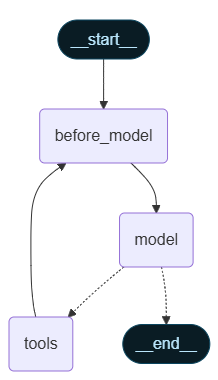 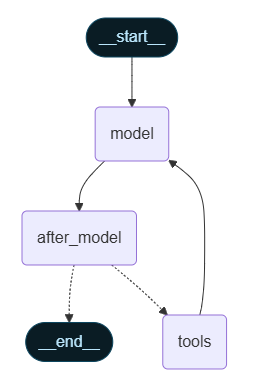 </div>

- Before Model

In [33]:
from langchain.messages import RemoveMessage, AIMessage
from langchain.agents.middleware import before_model
from langchain.agents import AgentState
from langgraph.runtime import Runtime
import re
from typing import Any

# --- 회사 정책 패턴 (간단 버전) ---
POLICY_PATTERNS = [
    r"password", r"api[_-]?key", r"secret",
    r"주민등록번호", r"internal", r"confidential"
]

@before_model
def check_security(state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
    """간단한 보안 검사 — 마지막 사용자 입력에 금칙어가 포함되어 있는지 확인."""
    messages = state["messages"]
    if not messages:
        return None

    # 가장 마지막 메시지의 내용 문자열 추출
    text = str(messages[-1].content)

    # 금칙어 탐지
    if any(re.search(p, text, re.IGNORECASE) for p in POLICY_PATTERNS):
        warning = (
            "보안 정책 위반 가능성이 있는 내용이 감지되었습니다!!!\n"
            "비밀번호, API 키, 주민등록번호 등 민감한 정보를 포함하지 말아주세요."
        )
        return {
            "messages": [
                RemoveMessage(id=messages[-1].id),  # 마지막 입력 제거
                AIMessage(content=warning),        # 경고 메시지 추가
            ]
        }

    # 이상 없으면 그대로 진행
    return None

agent = create_agent(
    model,
    tools=tools,
    middleware=[check_security],  # 보안 체크 미들웨어
    checkpointer=InMemorySaver(),  # 필요 시 단기 메모리 사용
)

config: RunnableConfig = {"configurable": {"thread_id": "1"}}

# 정책 위반 예시(차단됨)
response = agent.invoke({"messages": "내 API key 는 sk-123456 이고 비밀번호는 qwer1234"}, config)
response

{'messages': [HumanMessage(content='내 API key 는 sk-123456 이고 비밀번호는 qwer1234', additional_kwargs={}, response_metadata={}, id='aed8a762-ef07-4baa-92ae-c0125044f443'),
  AIMessage(content='API 키와 비밀번호는 민감한 정보이므로 직접적으로 다루거나 저장할 수 없습니다. 이 정보들은 안전한 방식으로 별도로 관리해 주시기 바랍니다.\n\n제공해주신 정보는 제가 직접 활용할 수 없으며, 고객 데이터베이스 검색과 같은 기능을 수행하기 위해서는 검색어를 알려주셔야 합니다. 어떤 고객 데이터를 조회하시겠어요?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--06db1294-7c42-4c17-98ca-eff394cf1d6e-0', usage_metadata={'input_tokens': 115, 'output_tokens': 76, 'total_tokens': 191, 'input_token_details': {'cache_read': 0}})]}

In [35]:
print(response['messages'][-1].content)

API 키와 비밀번호는 민감한 정보이므로 직접적으로 다루거나 저장할 수 없습니다. 이 정보들은 안전한 방식으로 별도로 관리해 주시기 바랍니다.

제공해주신 정보는 제가 직접 활용할 수 없으며, 고객 데이터베이스 검색과 같은 기능을 수행하기 위해서는 검색어를 알려주셔야 합니다. 어떤 고객 데이터를 조회하시겠어요?


- After Model

In [41]:
from langchain.messages import RemoveMessage
from langgraph.checkpoint.memory import InMemorySaver
from langchain.agents import create_agent, AgentState
from langchain.agents.middleware import after_model
from langgraph.runtime import Runtime

@after_model
def validate_response(state: AgentState, runtime: Runtime) -> dict | None:
    """정치적 또는 종교적 내용을 포함한 메시지를 자동으로 제거합니다."""
    
    # 정치/종교 관련 금칙어 목록 (필요 시 확장 가능)
    POLITICAL_OR_RELIGIOUS_WORDS = [
        "정치", "대통령", "선거", "정부", "야당", "여당",
        "보수", "진보", "민주당", "국민의힘", "정당",
        "종교", "기독교", "천주교", "불교", "이슬람", "힌두교",
        "신앙", "예수", "하느님", "알라", "교회", "성당", "사찰"
    ]
    
    last_message = state["messages"][-1]  # 모델의 마지막 응답 메시지
    content = str(last_message.content).lower()  # 내용 소문자로 변환
    
    # 금칙어 중 하나라도 포함되어 있으면 메시지 제거
    if any(word.lower() in content for word in POLITICAL_OR_RELIGIOUS_WORDS):
        print("정치/종교 관련 응답 감지 → 메시지 제거됨\n제거된 메시지 ==> ")
        print(content)
        return {"messages": [RemoveMessage(id=last_message.id)]}
    
    return None  # 문제가 없으면 그대로 유지

# 에이전트 생성
agent = create_agent(
    model,
    tools=[],
    middleware=[validate_response],  # 정치/종교 내용 필터 미들웨어
    checkpointer=InMemorySaver(),    # 단기 메모리(체크포인터)
)

In [42]:
# ==============================
# 테스트 코드
# ==============================
from langchain_core.runnables import RunnableConfig

# 스레드 ID 설정 (대화 단위 유지)
config: RunnableConfig = {"configurable": {"thread_id": "test_1"}}

print("[1] 정상 메시지 (삭제되지 않아야 함)")
result = agent.invoke({"messages": "오늘 날씨가 어때?"}, config)
print("→ 마지막 메시지:", result["messages"][-1].content)
print("-" * 60)

print("[2] 정치 관련 메시지 (삭제되어야 함)")
result = agent.invoke({"messages": "대통령 선거에 대해 어떻게 생각해?"}, config)
if len(result["messages"]) > 0:
    print("→ 마지막 메시지:", result["messages"][-1].content)
else:
    print("→ 메시지가 필터링되어 삭제되었습니다.")
print("-" * 60)

print("[3] 종교 관련 메시지 (삭제되어야 함)")
result = agent.invoke({"messages": "예수님은 누구인가요?"}, config)
if len(result["messages"]) > 0:
    print("→ 마지막 메시지:", result["messages"][-1].content)
else:
    print("→ 메시지가 필터링되어 삭제되었습니다.")
print("-" * 60)

[1] 정상 메시지 (삭제되지 않아야 함)
→ 마지막 메시지: 죄송하지만, 제가 계신 곳의 정확한 위치를 알 수 없어서 현재 날씨를 알려드리기가 어렵습니다.

**어느 지역의 날씨가 궁금하신가요? (예: 서울, 부산, 뉴욕 등)** 지역을 알려주시면 찾아드릴 수 있습니다.
------------------------------------------------------------
[2] 정치 관련 메시지 (삭제되어야 함)
정치/종교 관련 응답 감지 → 메시지 제거됨
제거된 메시지 ==> 
저는 인공지능이기 때문에 개인적인 의견이나 정치적인 견해를 가지고 있지 않습니다. 특정 후보나 정당에 대한 선호도 없이 중립적인 입장을 유지합니다.

하지만 대통령 선거가 **민주주의의 매우 중요한 과정**이라는 점은 말씀드릴 수 있습니다. 국민들이 자신들의 대표를 직접 뽑아 국가의 미래 방향을 결정하는 중대한 행사입니다. 다양한 정책과 비전이 제시되고, 국민들이 이를 바탕으로 신중하게 선택하는 과정이라고 생각합니다.
→ 마지막 메시지: 대통령 선거에 대해 어떻게 생각해?
------------------------------------------------------------
[3] 종교 관련 메시지 (삭제되어야 함)
정치/종교 관련 응답 감지 → 메시지 제거됨
제거된 메시지 ==> 
두 가지 질문에 대해 답변해 드릴게요.

---

**1. 대통령 선거에 대해 어떻게 생각해?**

저는 인공지능이므로 개인적인 생각이나 의견을 가지고 있지 않습니다. 대통령 선거와 같은 정치적 사안에 대해 특정 입장을 취하거나 판단을 내릴 수 없습니다.

하지만 대통령 선거의 중요성에 대해서는 말씀드릴 수 있습니다. 대통령 선거는 한 나라의 미래 방향을 결정하는 매우 중요한 과정입니다. 유권자들이 자신의 대표를 선택하여 국가 운영의 방향을 제시하고, 정책 결정에 영향을 미치는 민주주의의 핵심적인 절차입니다.

**제가 할 수 있는 일은 다음과 같습니다:**

*   **선거 과정 설명:**